In [1]:
# %matplotlib notebook
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from einops import rearrange, repeat
import time
import matplotlib.pyplot as plt
import numpy as np

## Check for GPU

In [2]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Get data

In [42]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

# cifar100 = torchvision.datasets.CIFAR100(root='../datasets', download=True)
cifar100_train = torchvision.datasets.CIFAR100(
    root='../datasets', 
    train=True,  # Important: Specify train=True
    transform=train_transform,
    download=True
)

cifar100_val = torchvision.datasets.CIFAR100(
    root='../datasets', 
    train=False,  # Using training set for validation
    transform=val_transform,
    download=True
)

# Create DataLoaders for training and validation
batch_size = 512
train_loader = torch.utils.data.DataLoader(
    cifar100_train, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True 
)
val_loader = torch.utils.data.DataLoader(
    cifar100_val, batch_size=batch_size, shuffle=False, num_workers=12
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Get a batch of images and their corresponding names
dataiter = iter(train_loader)
images, targets = next(dataiter)
images = images.to(device)

## Plot data

In [5]:
def show_batch(images, is_patches=False, patch_grid=None, line_width=1, line_color=(0, 0, 0)):
    """
    Display a batch of images or image patches with grid lines separating patches.
    """
    # Convert to CPU and make a copy
    images = images.cpu().clone().detach()

    # Denormalize
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(1, 3, 1, 1).to(images.device)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(1, 3, 1, 1).to(images.device)
    
    # Denormalize: undo the normalization
    images = images * std + mean

    # Ensure values are in valid range
    images = torch.clamp(images, 0, 1)
    
    if not is_patches:
        # For regular images, rearrange from [B, C, H, W] to [B, H, W, C]
        images = rearrange(images, 'b c h w -> b h w c')
        images = images.numpy()
    
    # Get number of images in batch
    batch_size = images.shape[0]
    
    # Calculate grid dimensions
    ncols = 4
    nrows = (batch_size + ncols - 1) // ncols  # Ceiling division to ensure all images fit
    
    # Create figure with larger size
    # Adjust these multipliers to change individual image size
    plt.figure(figsize=(4 * ncols, 4 * nrows))  # Each image gets roughly 4x4 inches
    
    # Create subplot grid
    for idx in range(batch_size):
        plt.subplot(nrows, ncols, idx + 1)
        plt.imshow(images[idx])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage:
# fig = show_batch(images, is_patches=False)

## Model architecture

In [6]:
C = images.shape[1]
H = images.shape[2]
W = images.shape[3]
patch_size = 4
num_patches = H*W // patch_size**2
emb_dim = 768
num_heads = 6
num_layers = 12
hidden_dim = 4*emb_dim
dropout = 0.3
n_classes = 100
img_shape = (H,W)
print(f"Number of channels (C): {C}")
print(f"Height (H): {H}")
print(f"Width (W): {W}")
print(f"Patch size (patch_size): {patch_size}")
print(f"Number of patches (num_patches): {num_patches}")
print(f"Embedding dimension (emb_dim): {emb_dim}")
print(f"Number of heads (num_heads): {num_heads}")
print(f"Head dimension: {emb_dim // num_heads}")
print(f"Number of transformer layers (num_layers): {num_layers}")
print(f"Hidden dimensions: {hidden_dim}")
print(f"Number of classes: {n_classes}")

Number of channels (C): 3
Height (H): 32
Width (W): 32
Patch size (patch_size): 4
Number of patches (num_patches): 64
Embedding dimension (emb_dim): 384
Number of heads (num_heads): 6
Head dimension: 64
Number of transformer layers (num_layers): 6
Hidden dimensions: 1536
Number of classes: 100


In [7]:
images.shape

torch.Size([256, 3, 32, 32])

In [8]:
# fig = show_batch(images.cpu(), is_patches=False)

## Patch 

In [9]:
import torch
import torch.nn as nn

class Patchify(nn.Module):
    def __init__(self, patch_size: int, C: int, img_shape: tuple, emb_dim: int):
        """
        Args:
            patch_size (int): Size of each patch (height and width).
            C (int): Number of input channels.
            img_shape (tuple): Shape of the input image (height, width).
            emb_dim (int): Dimension of the patch embeddings.
        """
        super(Patchify, self).__init__()
        self.patch_size = patch_size
        self.C = C
        self.h, self.w = img_shape
        self.emb_dim = emb_dim
        
        # Calculate the number of patches
        self.num_patches = (self.h // patch_size) * (self.w // patch_size)
        
        # Learnable class token (shape: (1, emb_dim))
        self.class_token = nn.Parameter(torch.randn(1, emb_dim))
        
        # Learnable positional embeddings (shape: (1, num_patches + 1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches + 1, emb_dim))
        
        # Linear projection layer (if patch embedding dimension != emb_dim)
        self.proj = nn.Linear(patch_size * patch_size * C, emb_dim) if patch_size * patch_size * C != emb_dim else nn.Identity()
        
        self.patch_emb_dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Input image tensor of shape (batch_size, C, H, W).
        
        Returns:
            torch.Tensor: Patch embeddings with class token and positional embeddings,
                          of shape (batch_size, num_patches + 1, emb_dim).
        """
        # Patchify the image: (batch_size, C, H, W) -> (batch_size, num_patches, patch_size * patch_size * C)
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        
        # Project patch embeddings to the embedding dimension (if necessary)
        x = self.proj(x)  # Shape: (batch_size, num_patches, emb_dim)
        
        # Get batch size dynamically
        batch_size = x.shape[0]
        
        # Expand class token to match batch size: (1, emb_dim) -> (batch_size, 1, emb_dim)
        class_token = repeat(self.class_token, '1 d -> b 1 d', b=batch_size)
        
        # Prepend the class token to the patch embeddings
        x = torch.cat([class_token, x], dim=1)  # Shape: (batch_size, num_patches + 1, emb_dim)
        
        # Add positional embeddings
        x = x + self.pos_emb  # Shape: (batch_size, num_patches + 1, emb_dim)
        
        x = self.patch_emb_dropout(x)
        
        return x

In [10]:
patchify = Patchify(patch_size=patch_size, C=C, img_shape=(H,W), emb_dim=emb_dim).to(device)
patches = patchify(images)
patches.shape

torch.Size([256, 65, 384])

In [11]:
## From a scratch
# import torch.nn.functional as F
# class MHSA(nn.Module):
#     def __init__(self, num_heads, emb_dim):
#         super(MHSA, self).__init__()
#         self.num_heads = num_heads
#         self.emb_dim = emb_dim
#         self.head_dim = emb_dim // num_heads 
#         self.wq = nn.Linear(emb_dim, emb_dim)
#         self.wk = nn.Linear(emb_dim, emb_dim)
#         self.wv = nn.Linear(emb_dim, emb_dim)
#         self.attn_dropout = nn.Dropout(dropout)
        
#     def forward(self, x):
#         batch_size, num_patches_plus_1, emb_dim = x.shape
#         q = self.wq(x) ## bs, num_patches + 1, emb_dim
#         k = self.wk(x) ## bs, num_patches + 1, emb_dim
#         v = self.wv(x) ## bs, num_patches + 1, emb_dim
#         q = rearrange(q, 'bs patches_plus_1 (num_heads head_size) -> bs num_heads patches_plus_1 head_size', num_heads=self.num_heads, head_size=self.head_dim)
#         k = rearrange(k, 'bs patches_plus_1 (num_heads head_size) -> bs num_heads patches_plus_1 head_size', num_heads=self.num_heads, head_size=self.head_dim)
#         v = rearrange(v, 'bs patches_plus_1 (num_heads head_size) -> bs num_heads patches_plus_1 head_size', num_heads=self.num_heads, head_size=self.head_dim)
#         attention_scores = q @ torch.transpose(k,-1,-2) * (self.head_dim ** -0.5)
#         attention_scores = F.softmax(attention_scores, dim=-1)
#         attention_scores = self.attn_dropout(attention_scores)
#         output = attention_scores @ v
#         output = rearrange(output, 'bs num_heads patch_size head_dim -> bs patch_size (head_dim num_heads)')
#         # return q, k, v, output
#         return output

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class MHSA(nn.Module):
    def __init__(self, num_heads, emb_dim):
        super().__init__()
        self.num_heads = num_heads
        self.emb_dim = emb_dim
        self.head_dim = emb_dim // num_heads
        
        # Combine QKV into single matrix for efficiency
        self.qkv = nn.Linear(emb_dim, 3 * emb_dim, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, num_patches_plus_1, emb_dim = x.shape
        
        # Single matrix multiplication for Q, K, V
        qkv = self.qkv(x)
        qkv = rearrange(qkv, 'b n (three h d) -> three b h n d', 
                       three=3, h=self.num_heads)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Use PyTorch's native scaled dot-product attention
        output = F.scaled_dot_product_attention(
            q, k, v,
            dropout_p=self.attn_dropout.p if self.training else 0.0,
            is_causal=False
        )
        
        # Reshape output
        output = rearrange(output, 'b h n d -> b n (h d)')
        
        return output
        

In [12]:
# mhsa = MHSA(num_heads, emb_dim).to(device)

In [13]:
# q, k, v, out = mhsa(patches)
# print(q.shape, k.shape, v.shape, out.shape)

In [14]:
class VITLayer(nn.Module):
    def __init__(self, num_heads, emb_dim, hidden_dim):
        super(VITLayer, self).__init__()
        self.ff_block = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                     nn.GELU(),
                                     nn.Dropout(dropout),
                                     nn.Linear(hidden_dim,emb_dim), 
                                     nn.Dropout(dropout))
        self.ff_norm = nn.LayerNorm(emb_dim)
        self.attention_norm = nn.LayerNorm(emb_dim)
        self.attention_block = MHSA(num_heads, emb_dim)
        
    def forward(self, x):
        x = x + self.attention_block(self.attention_norm(x))
        x = x + self.ff_block(self.ff_norm(x))
        
        return x
        

In [15]:
vit_layer = VITLayer(num_heads=num_heads, emb_dim=emb_dim, hidden_dim=emb_dim*4).to(device)

In [16]:
class VIT(nn.Module):
    def __init__(self, 
                 num_layers = num_layers, 
                 num_heads = num_heads, 
                 emb_dim = emb_dim, 
                 hidden_dim = hidden_dim, 
                 patch_size = patch_size,
                 C = C, 
                 img_shape = img_shape,
                 n_classes = n_classes):
        super(VIT,self).__init__()
        self.patch_embedding = Patchify(patch_size=patch_size, C=C, img_shape=img_shape, emb_dim=emb_dim)
        self.xfls = nn.ModuleList([VITLayer(num_heads=num_heads, 
                                               emb_dim=emb_dim, 
                                               hidden_dim=hidden_dim) 
                                  for i in range(num_layers)])
        self.norm = nn.LayerNorm(emb_dim)
        self.lin = nn.Linear(emb_dim, n_classes)
        
    def forward(self, x):
        x = self.patch_embedding(x)
        for layer in self.xfls:
            x = layer(x)
            
        x = self.norm(x)
        logits = self.lin(x)
        return logits[:, 0]

In [17]:
vit = VIT(num_layers = num_layers, 
                 num_heads = num_heads, 
                 emb_dim = emb_dim, 
                 hidden_dim = hidden_dim, 
                 patch_size = patch_size,
                 C = C, 
                 img_shape = img_shape,
                 n_classes = n_classes).to(device)
# vit.load_state_dict(torch.load('vit_weights.pth'))

In [18]:
## Calculate number of params
total_params = 0
for name, param in vit.named_parameters():
    if param.requires_grad:
        num_params = param.numel()
        print(f"{name}: {num_params:,} parameters")
        total_params += num_params
print(f"Total trainable parameters: {total_params:,}")

In [19]:
out = vit(images)
out.shape

torch.Size([256, 100])

In [20]:
## Checking initialization and making sure loss is reasonable
import torch.nn.functional as F
loss = F.cross_entropy(out.to('cpu'), targets)
loss

tensor(4.8031, grad_fn=<NllLossBackward0>)

In [21]:
# targets

In [22]:
## To continue training
# vit.load_state_dict(torch.load('vit_weights.pth'))

Epoch [1/100], Train Loss: 2.4511, Val Loss: 2.4719, Time: 8.86 seconds
Epoch [2/100], Train Loss: 2.4524, Val Loss: 2.4730, Time: 8.64 seconds
Epoch [3/100], Train Loss: 2.4508, Val Loss: 2.4694, Time: 8.45 seconds
Epoch [4/100], Train Loss: 2.4523, Val Loss: 2.4705, Time: 8.58 seconds
Epoch [5/100], Train Loss: 2.4609, Val Loss: 2.4645, Time: 8.61 seconds
Epoch [6/100], Train Loss: 2.4530, Val Loss: 2.4715, Time: 8.52 seconds
Epoch [7/100], Train Loss: 2.4559, Val Loss: 2.4702, Time: 8.50 seconds
Epoch [8/100], Train Loss: 2.4507, Val Loss: 2.4700, Time: 8.64 seconds
Epoch [9/100], Train Loss: 2.4462, Val Loss: 2.4686, Time: 8.63 seconds
Epoch [10/100], Train Loss: 2.4426, Val Loss: 2.4730, Time: 8.48 seconds
Epoch [11/100], Train Loss: 2.4468, Val Loss: 2.4683, Time: 8.52 seconds
Epoch [12/100], Train Loss: 2.4559, Val Loss: 2.4694, Time: 8.58 seconds
Epoch [13/100], Train Loss: 2.4451, Val Loss: 2.4689, Time: 8.55 seconds
Epoch [14/100], Train Loss: 2.4545, Val Loss: 2.4656, Time: 

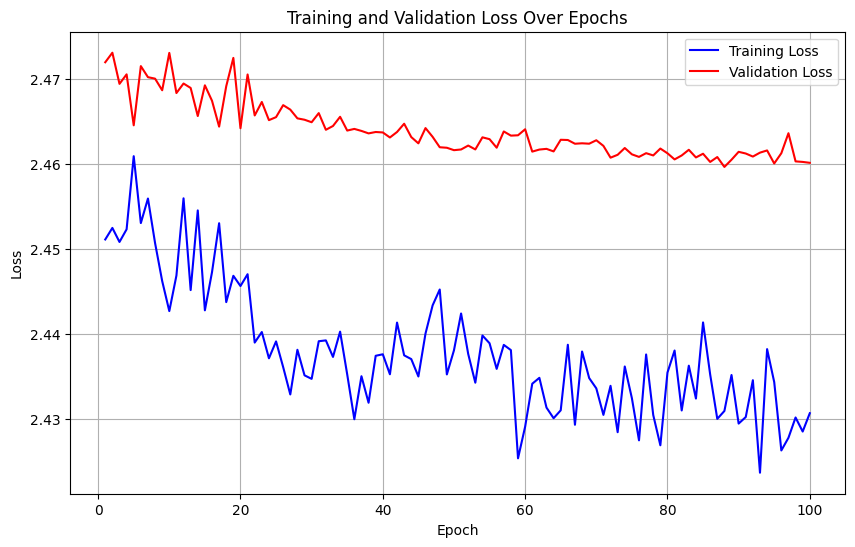

In [44]:
from accelerate import Accelerator
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import LinearLR

# Initialize accelerator
accelerator = Accelerator(mixed_precision='bf16')

# Hyperparameters
warmup_epochs = 5
num_epochs = 100
learning_rate = 1e-5

# Initialize optimizer
optimizer = optim.Adam(vit.parameters(), lr=learning_rate, weight_decay=1e-4)

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# scheduler = ReduceLROnPlateau(
#     optimizer, 
#     mode='min',
#     factor=0.1,
#     patience=5,
#     min_lr=1e-6
# )

scheduler_warmup = LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)


# Prepare model, dataloaders, and optimizer with accelerator
vit, optimizer, train_loader, val_loader = accelerator.prepare(
    vit, optimizer, train_loader, val_loader
)

# Training loop
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    # Training phase
    vit.train()
    running_train_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = vit(images)
        loss = F.cross_entropy(outputs, targets)
        
        # Use accelerator for backward pass
        accelerator.backward(loss)
        optimizer.step()
        running_train_loss += loss.item()
    
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    vit.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader):
            outputs = vit(images)
            loss = F.cross_entropy(outputs, targets)
            running_val_loss += loss.item()
    
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    # Print epoch statistics
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Time: {epoch_time:.2f} seconds')
    
    # Update the schedulers
    if epoch < warmup_epochs:
        scheduler_warmup.step()
    else:
        scheduler_plateau.step(val_loss)

# Save model weights (unwrap model first)
unwrapped_model = accelerator.unwrap_model(vit)
torch.save(unwrapped_model.state_dict(), 'vit_weights.pth')

# Plot the final training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Save model
# torch.save(vit.state_dict(), 'vit_weights.pth')
def save_weights(model, path):
    """
    Converts all model weights to bfloat16 before saving
    """
    bfloat16_state_dict = {
        key: value.to(torch.bfloat16) if value.dtype in [torch.float32, torch.float16] 
        else value
        for key, value in model.state_dict().items()
    }
    torch.save(bfloat16_state_dict, path)
    
save_weights(vit, 'vit_weights.pth')

In [ ]:
vit_test = VIT()
vit_test.load_state_dict(torch.load('vit_weights.pth'))
vit_test.to(device)
vit_test.eval()

In [ ]:
import torch
from tqdm import tqdm

def evaluate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels if you need them later
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Accuracy on validation set: {accuracy:.2f}%')
    
    return accuracy, all_preds, all_labels

# Run evaluation
accuracy, predictions, true_labels = evaluate(vit_test, val_loader, device)

In [ ]:
# Check dataset details
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of classes: {len(val_loader.dataset.classes) if hasattr(val_loader.dataset, 'classes') else 'Unknown'}")

# Check distribution of predictions
from collections import Counter
pred_distribution = Counter(predictions)
print(f"Number of unique predicted classes: {len(pred_distribution)}")
print(f"Min/Max predictions per class: {min(pred_distribution.values())}, {max(pred_distribution.values())}")